# Simple Tutorial

## Introduction

### Description

Depth map estimation for regular camera is a well studied topic in computer vision community. Many algorithms have been proposed in recent years, such as learning based mono depth estimation[?] and multiview geometry based depth estimation[?]. However, as these algorithms are based on regular camera model, depth estimation for omnidirectional camera is still a topic to be explored. 

The differences between regular cameras and omnidirectional cameras are shown in the Figure[?]. For a regular camera, the camera model can be simplified to a camera center plus an image plane. As long as the poses of cameras (from SfM or SLAM) and disparitise (from spares matching or dense matching) are estimated correctly, the depth map can be calculated easily. 

In comparison, for omnidirectional images (360 image), the "image plane" is a sphere. As a result, strong distortions are introduced by the projection from real scenes to the image sphere, leading to the failure of general sparse and dense matching algorithms. Since matching algorithms could not function correctly, disparity maps and the depth maps are relativelly difficult to be estimated. Besides, as the register operation introduces
more servere distortions[?], many classical algorithms are not applicable for 360 images. 

To solve the depth estimation problem for 360 images, here a cubic map based method is implemented. Since the main quesion is how to deal with the distortion caused the camera sphere, projecting a 360 image to its 6 tangent planes (6 cubic maps) is one of the most straght-forward way. The connections between 360 image and cubic maps are shown in Figure[?]. 

After cube projection, 360 images are decomposed to cubic maps, which can be treated as regular images. In addition, the camera parameters corresponding to these cubic maps can be easily obtained from original 360 images.  Thus, it is possible to use availabel algorithms to estimate depth map for each of these cubic maps. 

Finally, with estimated cubic depth maps, a inverse projection from cubic maps to 360 images can generate the final 360 depth maps. 

In this project, the above cubic maps based method is implemented. Depth estimation for the cubic maps is based on the [colmap](https://colmap.github.io/), the patch matching stereo GPU part. 

This tutorial includes two parts:
1. a simple introduction of the provided cubemap class; 
2. an example of the wrapper for 360 depthmap estimation.

### Prerequisites

- [Linux]() or Max. As the installtion of [pyshtools]() does not work well on Windows, this project is only tested on Ubuntu 18.04. 

- To use cubemap functions, you have to install [numpy](), [matplotlib](), [scipy](),[OpenCV](), [pyshtools]() and [interpolation]().

- To execute the wrapper correctly, a computer equiped with [Nvidia GPUs]() (at least 4GB memory) is necessary. Besides, you have to install [colmap](https://colmap.github.io/).

## Cubemap functions

#### Import packages

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from cam360 import Cam360
from cubicmaps import CubicMaps

#### Read image

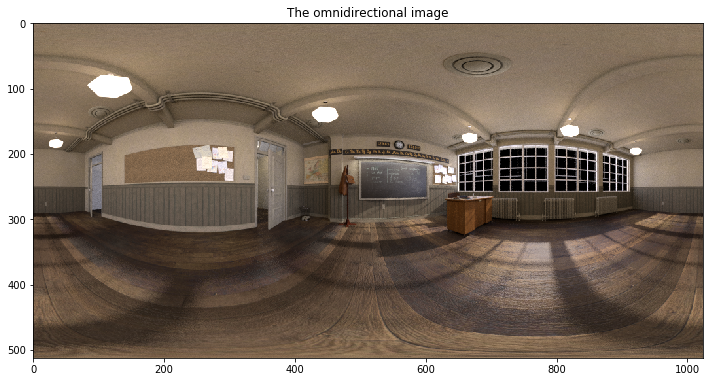

In [2]:
# path to the image
Image_path = '../data_demo/dataset/test_0_0_1_1024_512_0111.png'

# the pose of the camera corresponding to the image
camera_pose = [np.eye(3), np.array([0, 0, 1])]

# read the image and make it in RGB order
Omni_img = np.flip(cv2.imread(Image_path), axis=2)   
Omni_img = Omni_img/np.max(Omni_img)

# show the loaded image
plt.figure(figsize=[12,8])
plt.imshow(Omni_img)
plt.title('The omnidirectional image');

Here the coordinate is defined as follow:
1. Right-hand coordinate is used here: x axis points to the right, y axis to the front and z axis to the sky.
2. "theta" is the angle between the z-axis and the ray pointing from the origin to the pixel on the camera sphere; Thus it is related to rows of a 360 image.
3. "phi" is the angle between the negative y axis and the plane formed by the pixel and z axis; thus it is related to columns of a 360 image. 
4. The range of columns (phi) of an 360 image is $[0, 2\pi]$ and the range of rows (theta) is $[0, \pi]$

Therefore, for an omnidirectional image as above, the textures from left to the right are: back(left side), left, front, right, back(right side)

#### Create a Cam360 object and then decompose it into 6 cubic maps

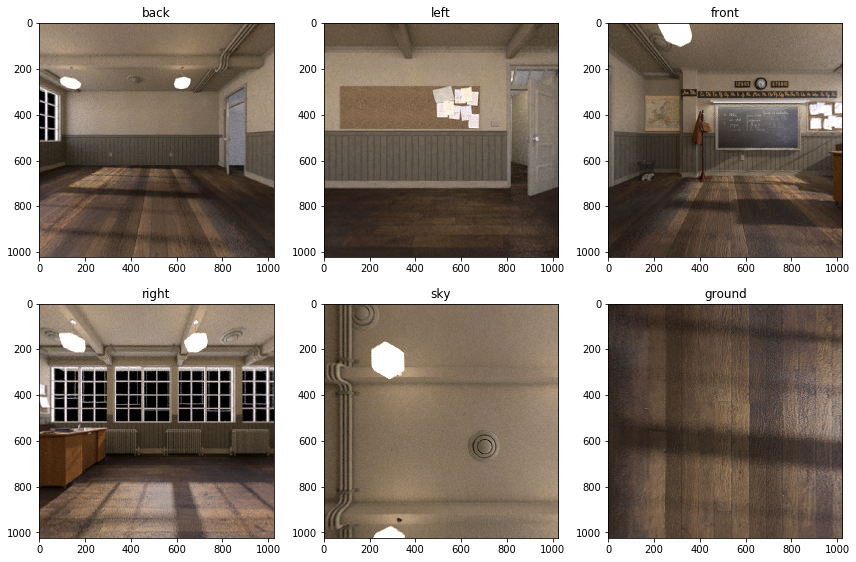

In [3]:
# generate a CubicMaps and a Cam360 object
cubemap_obj = CubicMaps()

Cam360_obj  = Cam360(rotation_mtx = camera_pose[0], 
                     translation_vec = camera_pose[1], 
                     height = Omni_img.shape[0], 
                     width  = Omni_img.shape[1], 
                     channels = Omni_img.shape[2], 
                     texture  = Omni_img)

# decompose the Cam360 object into cubic maps with the specified resolution
# the 6 cubic maps are output and they are stored at obj.cubemap as well.
cubemap_obj.sphere2cube(Cam360_obj, resolution=[1024, 1024])

order = ['back', 'left', 'front', 'right', 'sky', 'ground']
plt.figure(figsize=[12,8])
for ct in range(len(cubemap_obj.cubemap)):
    plt.subplot(2,3,ct+1)
    plt.imshow(cubemap_obj.cubemap[ct])
    plt.title(order[ct])
    plt.tight_layout()

#### If only a tangent plane at a given angle is required.

Here we assume that we want to project the 360 image to its tangent plane at $\phi = \pi$, $\theta = \pi/3$, with fov = $\pi/6$ for $\phi$ and $\theta$.

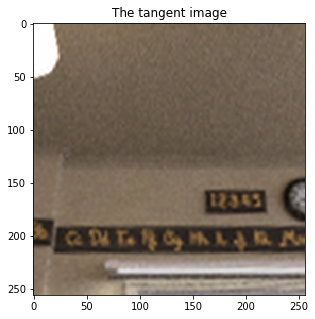

In [14]:
tangent = cubemap_obj.cube_projection(cam=Cam360_obj, 
                                      direction=(np.pi, np.pi/3, np.pi/6, np.pi/6),
                                      resolution=[256,256])


plt.figure(figsize=[10,5])
plt.imshow(tangent)
plt.title('The tangent image');

#### Merge 6 cubic maps to obtain a 360 image

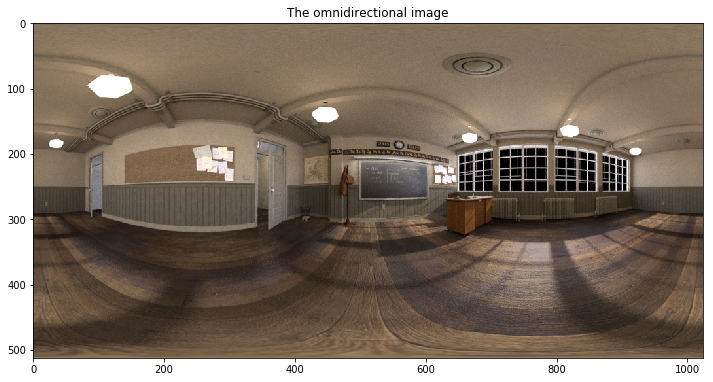

In [4]:
# use the function to covert cubic maps to 360 images, the result is stored at obj.omnimage
cubemap_obj.cube2sphere_fast(resolution=[512,1024])

# show the recovered omnidirectional image
plt.figure(figsize=[12,8])
plt.imshow(cubemap_obj.omnimage)
plt.title('The omnidirectional image');

## Depth estimation

The depth estimation is based on the [patch matching stereo]() function of [colmap](). To estimate depth map for a 360 image, two ways are supported:
1. giving a list of Cam360 objects;
2. giving the path to the image sets;

The later is based on the former with addition operations of loading images into a list of Cam360 objects.

#### 1. Giving a list of Cam360 objects

The **dense_from_cam360list()** in workspace_helper.py realizes this function. Given a list of cam360 objects and some required parameters, it estimates corresponding depthmaps.

Firstly, it generates cubic maps for all objects. Then it collects cubic maps according to the view (back/front/laft/right) and saves diffetent views to corresponding folders (workspace/cubemaps/view0, workspace/cubemaps/view1, etc.). At the same time, it generates the camera models as well as the camera poses and save these data as .txt file to workspace/cubemaps/parameters/view* for patch matching stereo.

After preparation, it calls Patch Matching Stereo GPU module of colmap to work on cubic maps and reorganize the estimated depth maps to /workspace/omni_depthmaps/image_name/.

Finally, it reproject the cubic depth maps back to the 360 camera to obtain the omnidirectional depth map.

#### 2. Giving the path to the image set

The **dense_reconstruct.py** realizes this function and can be run on the commandline directly. To use the script, python version should be 3.+ . The lastest release of python is prefered.

Usage:
python dense_reconstruct.py [-h] 
                            [--path_to_image]
                            [--patchmatch_path]
                            [--workspace]
                            [--reference_image]
                            [--views_for_synthesis]
                            [--use_colmap]
                            [--pose_list ...]
                            
optional arguments: <br>
  **-h, --help**        show this help message and exit  <br>
  **--path_to_image**   where the 360 imagses are stored <br>
  **--patchmatch_path** Where is the exectable file of patch matching stereo GPU <br>
  **--workspace**       Where to store the workspace <br>
  **--reference_image** Which image is the used as the reference image to create the world coordinate <br>
  **--views_for_synthesis** The number of views to synthesize the 360 depthmap; only 4 and 6 are supported <br>
  **--use_colmap**      Use orignal colmap or the modified PatchMatchingStereoGPU adapted from colmap <br>
  **--pose_list** POSE_LIST [POSE_LIST ...] A list of pose corresponding to the images.
  


---